## Análisis del *target* de engagement

En este notebook buscaremos la mejor forma de definir la variable objetivo (**target**) que
resuma el interés de los usuarios por cada POI.  
Analizaremos las métricas disponibles (`Visits`, `Likes`, `Bookmarks`, `Dislikes`) y
decidiremos:

1. Si combinarlas en un único *engagement score*.
2. Qué transformaciones aplicar para reducir sesgo (`log1p`).
3. Si convertirlo en problema de **regresión** o **clasificación** (alto/bajo engagement).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
data = pd.read_csv('poi_dataset.csv')

In [8]:
# Vamos a visualizar los campos de Visits, Likes, Bookmarks, Dislikes
visits = data['Visits'].fillna(0)
print("Visits statistics:")
print(visits.describe())
print("\n")

print("Likes statistics:")
print(data['Likes'].describe()) 
print("\n")

print("Bookmarks statistics:")
print(data['Bookmarks'].describe())
print("\n")

print("Dislikes statistics:")
print(data['Dislikes'].describe())


Visits statistics:
count     1569.000000
mean     10011.943276
std          5.456808
min      10001.000000
25%      10008.000000
50%      10011.000000
75%      10015.000000
max      10038.000000
Name: Visits, dtype: float64


Likes statistics:
count     1569.000000
mean      3623.908222
std       4817.879374
min        100.000000
25%        464.000000
50%       1434.000000
75%       6840.000000
max      26425.000000
Name: Likes, dtype: float64


Bookmarks statistics:
count    1569.000000
mean      973.261950
std      1453.333948
min        50.000000
25%       116.000000
50%       306.000000
75%      1309.000000
max      8157.000000
Name: Bookmarks, dtype: float64


Dislikes statistics:
count     1569.000000
mean      2526.305927
std       2225.543360
min         52.000000
25%        937.000000
50%       2718.000000
75%       3399.000000
max      10999.000000
Name: Dislikes, dtype: float64


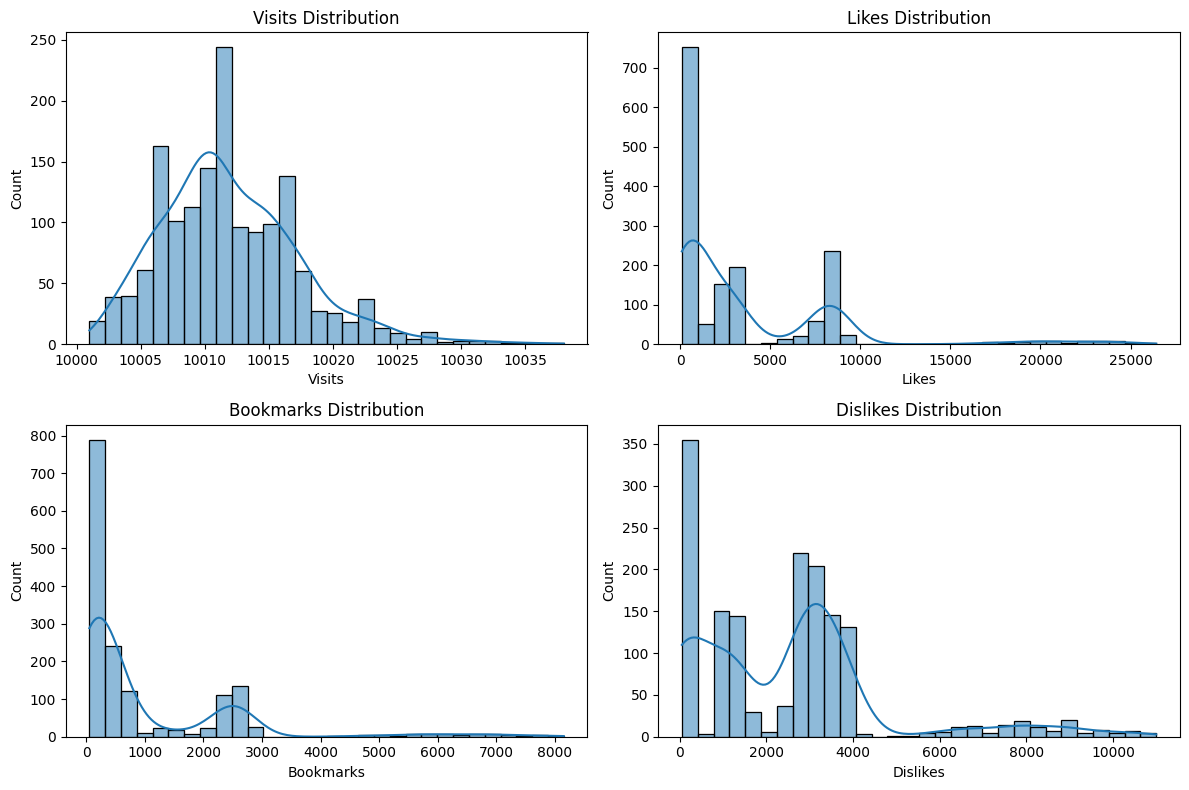

In [9]:
#generamos histogramas para cada uno de los campos
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(visits, bins=30, kde=True)
plt.title('Visits Distribution')
plt.subplot(2, 2, 2)
sns.histplot(data['Likes'], bins=30, kde=True)
plt.title('Likes Distribution')
plt.subplot(2, 2, 3)
sns.histplot(data['Bookmarks'], bins=30, kde=True)
plt.title('Bookmarks Distribution')
plt.subplot(2, 2, 4)
sns.histplot(data['Dislikes'], bins=30, kde=True)
plt.title('Dislikes Distribution')
plt.tight_layout()
plt.show()

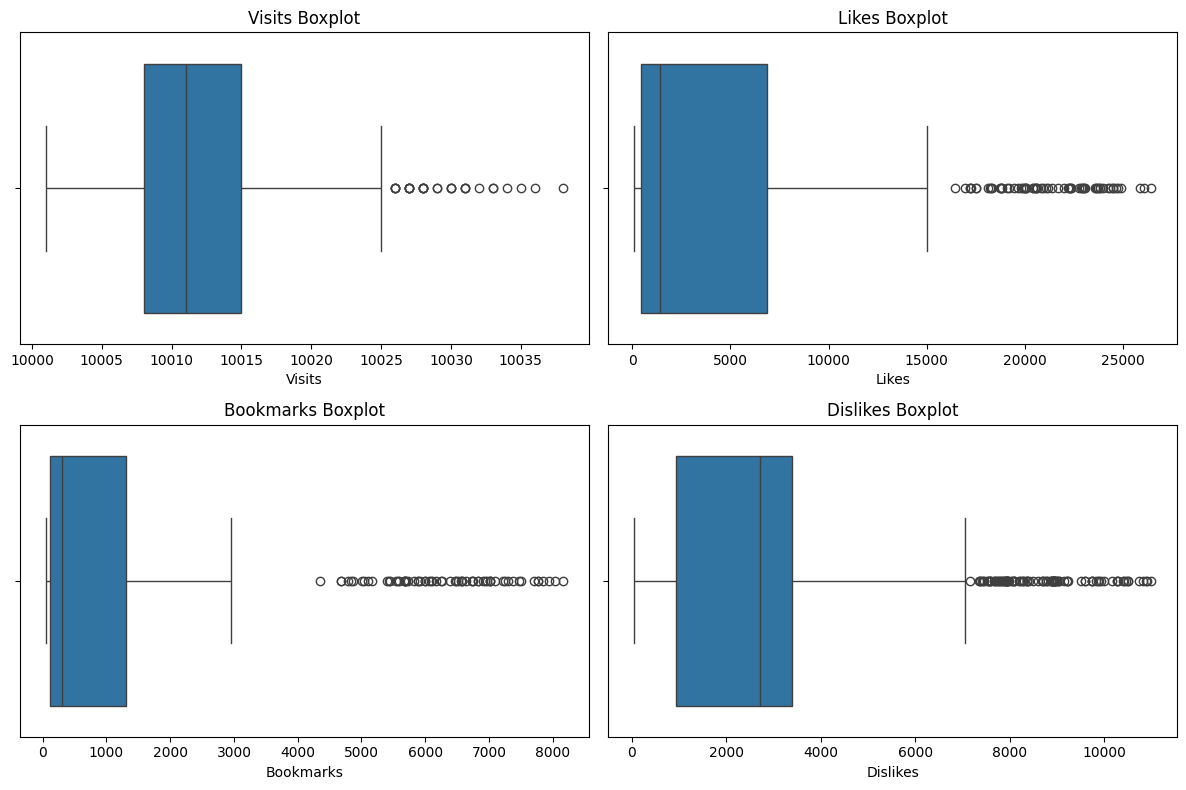

In [10]:
#Vamos a visualzar con unos boxplots los datos de Visits, Likes, Bookmarks, Dislikes
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x=visits)
plt.title('Visits Boxplot')
plt.subplot(2, 2, 2)
sns.boxplot(x=data['Likes'])
plt.title('Likes Boxplot')
plt.subplot(2, 2, 3)
sns.boxplot(x=data['Bookmarks'])
plt.title('Bookmarks Boxplot')
plt.subplot(2, 2, 4)
sns.boxplot(x=data['Dislikes'])
plt.title('Dislikes Boxplot')
plt.tight_layout()
plt.show()


### Análisis exploratorio de las métricas de engagement

| Métrica | Lectura |
|---------|---------|
| **Visits** | Extremadamente **concentrada**: todos los POIs rondan idéntico nº de visitas. Aporta poca varianza , podría tener escaso poder predictivo. |
| **Likes** | **Cola larga** y fuerte sesgo a la derecha. Gran dispersión: desde 100 hasta > 26 k. Necesario `log1p`  |
| **Bookmarks** | Patrón similar a *Likes* pero a menor escala. Alta asimetría y varios outliers. |
| **Dislikes** | También muy sesgada; valores desde 52 hasta ~11 k. Interesante para medir polaridad junto con *Likes*. 

**Observaciones clave a partir de los histogramas y boxplots**

* `Visits` muestra una barra prácticamente “monolítica”; su **varianza mínima** sugiere descartarla o tratarla como constante.
* `Likes`, `Bookmarks` y `Dislikes` presentan **colas largas** con numerosos puntos fuera de los bigotes en los boxplots → claros outliers.
* La dispersión relativa (*coef. de variación*) es especialmente alta en `Likes` (σ > µ) y `Bookmarks`, indicando que la media no representa bien la tendencia central.
* Visualmente se distinguen **múltiples “modos” o picos** en Likes y Dislikes (probables grupos de popularidad).

**Próximas acciones sugeridas**

1. Aplicar `np.log1p()` a `Likes`, `Bookmarks` y `Dislikes` para suavizar colas y acercar la distribución a la normalidad.
2. Crear un **`eng_score`** preliminar:  

$$
\text{engagement\_score}\;=\;
\underbrace{\log\!\bigl(1 + \text{Likes} + \text{Bookmarks}\bigr)}_{\text{feedback positivo}}
\;-\;
\underbrace{\log\!\bigl(1 + \text{Dislikes}\bigr)}_{\text{feedback negativo}}
$$


4. descartado `Visits` dado su rango tan limitado.

> *Conclusión:* Las métricas basadas en likes y reacciones contienen variabilidad suficiente para un modelo de engagement, mientras que `Visits` no aporta información diferenciadora.


count    1569.000000
mean        0.385094
std         2.669090
min        -3.214023
25%        -1.901305
50%        -0.992648
75%         1.345506
max         5.415450
Name: engagement_score, dtype: float64


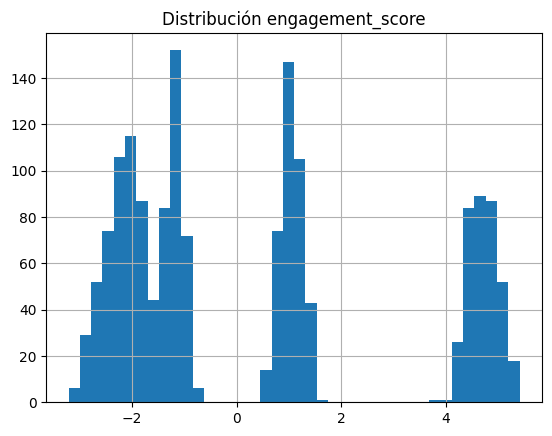

In [11]:

#Crear score 
eng_pos = np.log1p(data['Likes'] + data['Bookmarks'])
eng_neg = np.log1p(data['Dislikes'])
data['engagement_score'] = eng_pos - eng_neg

#Inspección rápida 
print(data['engagement_score'].describe())

#Histograma 
data['engagement_score'].hist(bins=40); plt.title("Distribución engagement_score")

#Eliminar columnas redundantes
cols_to_drop = ['Likes', 'Bookmarks', 'Dislikes', 'Visits']
data.drop(columns=cols_to_drop, inplace=True)


In [15]:
labels = ['Low', 'Mid', 'High']
data['eng_cat'] = pd.qcut(
    data['engagement_score'],
    q=3,
    labels=labels
)


print(data['eng_cat'].value_counts())

eng_cat
Low     523
Mid     523
High    523
Name: count, dtype: int64


### Análisis del **`engagement_score`**


#### Estadísticos descriptivos

| count | mean | std  | min | 25 % | 50 % | 75 % | max |
|-------|------|------|-----|------|------|------|-----|
| 1 569 | **0.386** | 2.669 | –3.214 | –1.901 | –0.992 | **1.345** | 5.415 |

* Media cercana a **0** → balance global entre señales positivas y negativas.  
* **Rango amplio** (≈ 8.6 pts) y **σ ≈ 2.7** ⇒ suficiente varianza para aprendizaje.  
* El histograma muestra tres picos bien diferenciados:

  1. Zona **negativa** (–3 a –1)  
  2. Zona **casi neutra** (≈ –1 a 1.3)  
  3. Zona **alta** (≳ 4)

  Esto sugiere tres “niveles naturales” de engagement.

---

#### Categorización del target

Se discretizó el score en **terciles** con `pd.qcut(q=3)`:

| Clase (`eng_cat`) | Rango de score | Tamaño |
|-------------------|----------------|--------|
| **Low**  |   ⩽ p33 (≈ –1.9) | ≈ 1/3 |
| **Mid**  | p33 – p66 (–1.9 ↔ 1.35) | ≈ 1/3 |
| **High** |  ≥ p66 (≈ 1.35) | ≈ 1/3 |

> *Ventaja:* clases equilibradas facilitan el entrenamiento de un clasificador  





In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                1569 non-null   object  
 1   name              1569 non-null   object  
 2   shortDescription  1569 non-null   object  
 3   categories        1569 non-null   object  
 4   tier              1569 non-null   int64   
 5   locationLon       1569 non-null   float64 
 6   locationLat       1569 non-null   float64 
 7   tags              1569 non-null   object  
 8   xps               1569 non-null   int64   
 9   main_image_path   1569 non-null   object  
 10  engagement_score  1569 non-null   float64 
 11  eng_cat           1569 non-null   category
dtypes: category(1), float64(3), int64(2), object(6)
memory usage: 136.6+ KB


C:\Users\Nauzet\AppData\Local\Temp\ipykernel_7624\155957982.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




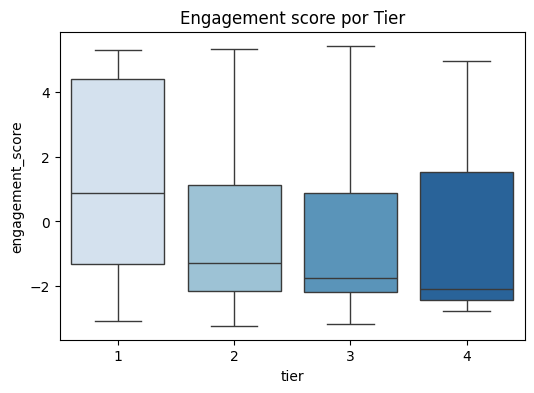

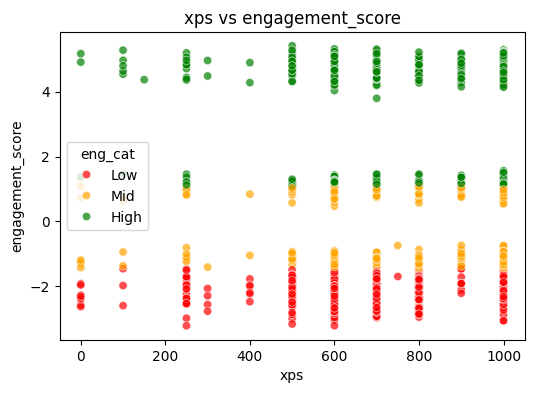

In [21]:
# --- 1. tier vs engagement_score -------------------------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x='tier', y='engagement_score', data=data, palette='Blues')
plt.title('Engagement score por Tier'); plt.show()

# --- 2. xps vs engagement_score --------------------------------------------
plt.figure(figsize=(6,4))
sns.scatterplot(x='xps', y='engagement_score', hue='eng_cat',
                data=data, palette={'Low':'red','Mid':'orange','High':'green'},
                alpha=0.7)
plt.title('xps vs engagement_score'); plt.show()





#### `tier` vs `engagement_score`
* **Tendencia inversa a lo esperado**: el *tier 1* (POIs de menor “relevancia oficial”) presenta la mediana de **engagement más alta** y una varianza amplia; los *tier 3–4* concentran valores negativos.  
* **Hipótesis**  
  1. Los POIs de tier bajo podrían corresponder a espacios populares/locales con alta participación social.  
  2. El cálculo de `tier` y el de reacciones proviene de fuentes distintas y no están alineados temporalmente.  
* **Implicación** → No usaremos `tier` como proxy directo de interés; lo trataremos como feature ordinal pero *no* como sustituto del target.

In [23]:
# Guardamos el dataset modificado en un nuevo archivo CSV
data.to_csv('poi_dataset_engagment.csv', index=False)